In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 7551
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  4MPGEE3V_23_50_20
NN-MODEL FILENAME:  ./models/4MPGEE3V_23_50_20_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1283.33 MiB, increment: 1063.50 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15739
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 67
TOTAL SERIAL TIMESTEPS:   15739
TOTAL PARALLEL TIMESTEPS: 67


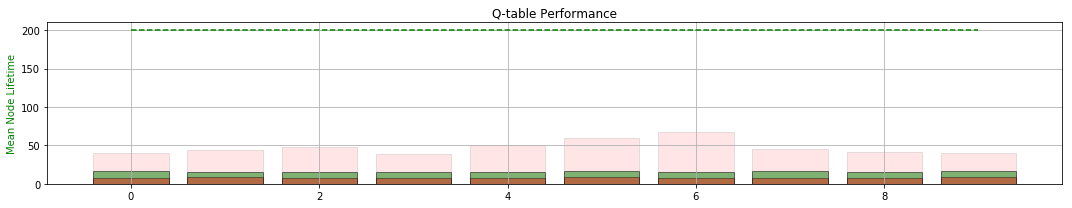

MEMORY COUNTER:  15739
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 548.322	LOSS : 507.571	LOSS : 492.247	LOSS : 489.383	LOSS : 460.647	LOSS : 458.821	LOSS : 441.433	LOSS : 425.385	LOSS : 428.318	LOSS : 437.223	LOSS : 424.755	LOSS : 443.791	LOSS : 410.728	LOSS : 389.161	LOSS : 384.962	LOSS : 401.136	LOSS : 376.660	LOSS : 385.635	LOSS : 367.909	LOSS : 380.951	
Validating... MEAN TIME:  115.045
LOSS : 361.435	LOSS : 362.966	LOSS : 352.076	LOSS : 367.790	LOSS : 354.632	LOSS : 364.617	LOSS : 349.678	LOSS : 367.929	LOSS : 371.447	LOSS : 366.877	LOSS : 355.619	LOSS : 359.772	LOSS : 360.617	LOSS : 355.663	LOSS : 374.723	LOSS : 375.707	LOSS : 360.560	LOSS : 362.508	LOSS : 368.325	LOSS : 368.339	
Validating... MEAN TIME:  136.25
LOSS : 367.250	LOSS : 366.286	LOSS : 377.025	LOSS : 388.893	LOSS : 365.240	LOSS : 369.991	LOSS : 392.569	LOSS : 383.765	LOSS : 389.588	LOSS : 382.288	LOSS : 377.940	LOSS : 379.949	LOSS : 391.031	LOSS : 396.933	LOSS : 417.376	LOSS : 411.644	LOSS : 39

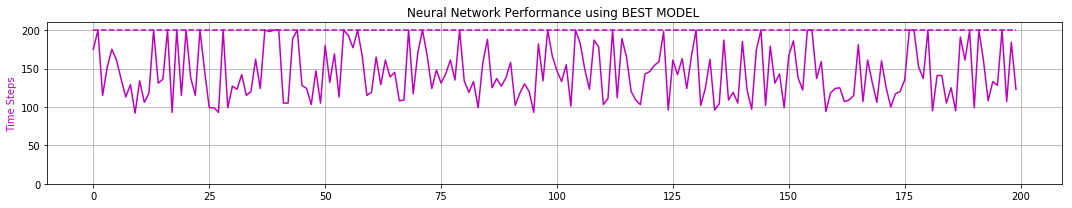

peak memory: 1337.93 MiB, increment: 1057.43 MiB
0 -max- [ 0.321  2.060  0.204  2.208]
0 -min- [-0.182 -1.406 -0.209 -2.966]

1 -max- [ 0.446  2.133  0.205  1.707]
1 -min- [-0.072 -0.965 -0.209 -2.771]

2 -max- [ 0.342  1.949  0.192  1.406]
2 -min- [-0.140 -0.824 -0.209 -2.931]

3 -max- [ 0.228  1.978  0.199  1.901]
3 -min- [-0.125 -1.144 -0.209 -2.733]

4 -max- [ 0.343  2.174  0.208  1.821]
4 -min- [-0.213 -1.185 -0.209 -2.844]

5 -max- [ 0.490  2.837  0.209  2.085]
5 -min- [-0.170 -1.348 -0.209 -3.049]

6 -max- [ 0.982  2.986  0.208  1.737]
6 -min- [-0.138 -1.001 -0.209 -2.728]

7 -max- [ 0.514  2.298  0.208  1.747]
7 -min- [-0.173 -0.986 -0.209 -2.960]

8 -max- [ 0.363  2.320  0.205  1.557]
8 -min- [-0.138 -1.028 -0.209 -2.877]

9 -max- [ 0.480  2.716  0.208  2.153]
9 -min- [-0.166 -1.400 -0.209 -2.887]

Quantization TIME:  0.01 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   94330
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   110069
TOTAL PARALLEL TIM

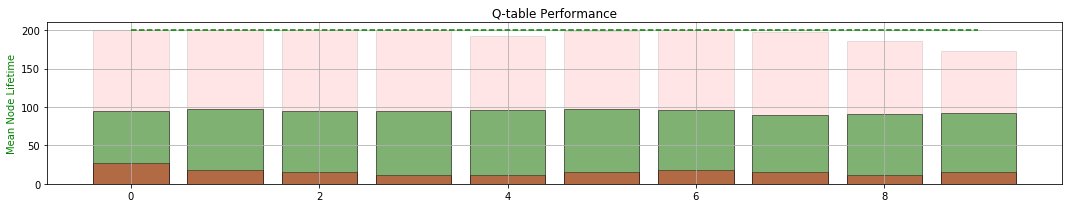

MEMORY COUNTER:  110069
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 376.040	LOSS : 301.959	LOSS : 281.230	LOSS : 272.688	LOSS : 264.402	LOSS : 224.751	LOSS : 232.798	LOSS : 209.553	LOSS : 220.865	LOSS : 206.141	LOSS : 213.091	LOSS : 227.585	LOSS : 222.606	LOSS : 225.281	LOSS : 209.470	LOSS : 221.904	LOSS : 214.827	LOSS : 220.053	LOSS : 222.791	LOSS : 223.919	
Validating... MEAN TIME:  95.91
LOSS : 211.489	LOSS : 204.622	LOSS : 223.196	LOSS : 218.754	LOSS : 232.273	LOSS : 214.915	LOSS : 217.913	LOSS : 219.714	LOSS : 224.271	LOSS : 225.782	LOSS : 223.202	LOSS : 216.101	LOSS : 217.303	LOSS : 205.138	LOSS : 206.609	LOSS : 215.296	LOSS : 228.207	LOSS : 215.840	LOSS : 218.377	LOSS : 224.758	
Validating... MEAN TIME:  107.355
LOSS : 219.714	LOSS : 224.431	LOSS : 221.058	LOSS : 223.690	LOSS : 246.591	LOSS : 229.917	LOSS : 217.633	LOSS : 231.511	LOSS : 228.927	LOSS : 235.955	LOSS : 231.992	LOSS : 246.163	LOSS : 221.682	LOSS : 250.326	LOSS : 228.974	LOSS : 246.373	LOSS : 25

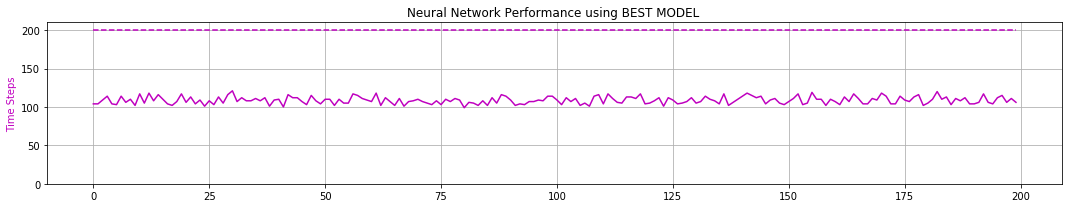

peak memory: 1380.93 MiB, increment: 1022.36 MiB
0 -max- [ 0.883  1.663  0.208  1.767]
0 -min- [-1.437 -2.068 -0.209 -2.305]

1 -max- [ 0.657  1.522  0.208  1.730]
1 -min- [-1.116 -2.037 -0.209 -2.117]

2 -max- [ 0.799  1.455  0.209  2.239]
2 -min- [-1.203 -2.025 -0.209 -1.999]

3 -max- [ 0.799  1.532  0.209  1.946]
3 -min- [-1.300 -2.438 -0.209 -2.024]

4 -max- [ 0.804  1.880  0.209  2.105]
4 -min- [-1.199 -2.238 -0.209 -1.943]

5 -max- [ 0.793  1.569  0.209  2.218]
5 -min- [-1.326 -2.252 -0.209 -2.318]

6 -max- [ 0.793  2.077  0.209  2.259]
6 -min- [-1.113 -2.262 -0.209 -2.745]

7 -max- [ 0.795  1.485  0.209  2.179]
7 -min- [-1.402 -2.417 -0.209 -1.902]

8 -max- [ 1.176  1.677  0.208  1.752]
8 -min- [-1.160 -2.007 -0.209 -2.436]

9 -max- [ 0.806  1.718  0.208  2.099]
9 -min- [-1.122 -2.089 -0.209 -2.001]

Quantization TIME:  0.02 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   69923
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 120
TOTAL SERIAL TIMESTEPS:   179992
TOTAL PARALLEL TIM

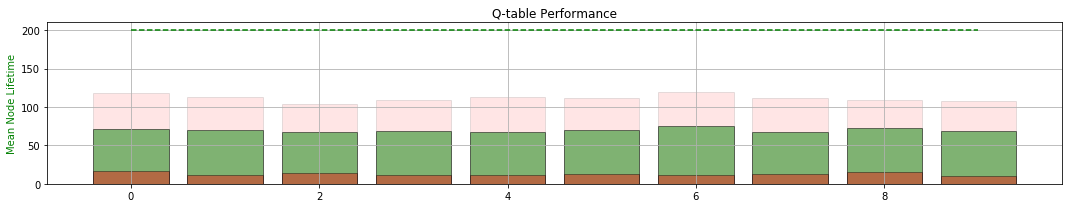

MEMORY COUNTER:  179992
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 291.405	LOSS : 298.385	LOSS : 306.753	LOSS : 297.072	LOSS : 279.238	LOSS : 294.725	LOSS : 271.722	LOSS : 283.093	LOSS : 289.588	LOSS : 252.265	LOSS : 267.732	LOSS : 263.005	LOSS : 243.990	LOSS : 251.975	LOSS : 249.971	LOSS : 252.850	LOSS : 255.747	LOSS : 252.015	LOSS : 261.720	LOSS : 261.248	
Validating... MEAN TIME:  109.36
LOSS : 269.009	LOSS : 257.753	LOSS : 235.976	LOSS : 258.897	LOSS : 270.850	LOSS : 249.039	LOSS : 260.859	LOSS : 260.748	LOSS : 278.985	LOSS : 272.495	LOSS : 257.866	LOSS : 269.410	LOSS : 256.546	LOSS : 271.958	LOSS : 247.968	LOSS : 268.140	LOSS : 261.890	LOSS : 231.995	LOSS : 253.171	LOSS : 255.566	
Validating... MEAN TIME:  114.38
LOSS : 237.074	LOSS : 262.776	LOSS : 273.425	LOSS : 267.432	LOSS : 273.533	LOSS : 279.461	LOSS : 281.069	LOSS : 251.457	LOSS : 262.693	LOSS : 269.863	LOSS : 261.446	LOSS : 279.301	LOSS : 269.761	LOSS : 276.105	LOSS : 268.965	LOSS : 255.571	LOSS : 27

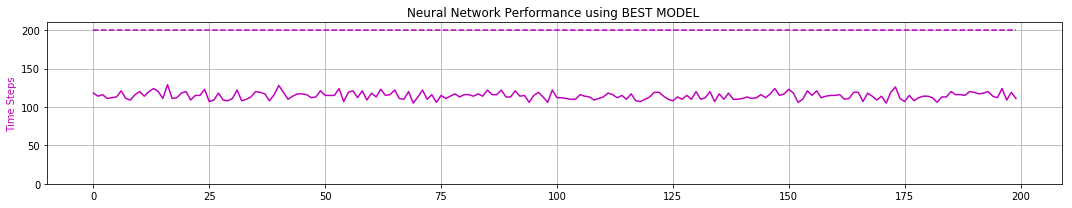

peak memory: 1408.68 MiB, increment: 1022.00 MiB
0 -max- [ 0.163  1.023  0.051  1.431]
0 -min- [-2.398 -3.707 -0.209 -1.488]

1 -max- [ 0.180  1.200  0.066  1.431]
1 -min- [-2.396 -3.735 -0.209 -1.588]

2 -max- [ 0.171  1.204  0.058  1.600]
2 -min- [-2.397 -3.841 -0.209 -1.692]

3 -max- [ 0.181  1.185  0.055  1.554]
3 -min- [-2.399 -3.870 -0.209 -1.669]

4 -max- [ 0.186  1.200  0.050  1.596]
4 -min- [-2.395 -3.733 -0.209 -1.758]

5 -max- [ 0.209  1.147  0.053  1.612]
5 -min- [-2.400 -3.849 -0.209 -1.724]

6 -max- [ 0.212  1.125  0.060  1.405]
6 -min- [-2.400 -3.691 -0.209 -1.741]

7 -max- [ 0.196  1.352  0.061  1.682]
7 -min- [-2.396 -3.938 -0.209 -2.158]

8 -max- [ 0.190  1.012  0.049  1.503]
8 -min- [-2.396 -3.747 -0.209 -1.706]

9 -max- [ 0.203  1.171  0.053  1.355]
9 -min- [-2.396 -3.696 -0.209 -1.811]

Quantization TIME:  0.01 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   78218
SMALLEST TIMESTEP: 23
LARGEST  TIMESTEP: 107
TOTAL SERIAL TIMESTEPS:   258210
TOTAL PARALLEL TIM

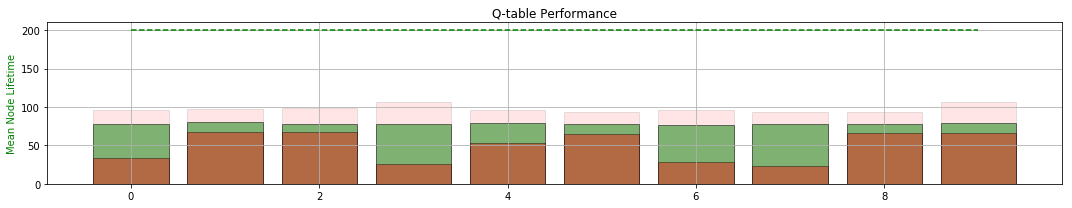

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 215.155	LOSS : 198.088	LOSS : 190.677	LOSS : 196.607	LOSS : 181.919	LOSS : 180.591	LOSS : 178.705	LOSS : 186.051	LOSS : 186.882	LOSS : 188.053	LOSS : 183.418	LOSS : 185.381	LOSS : 183.402	LOSS : 176.385	LOSS : 192.883	LOSS : 185.426	LOSS : 184.784	LOSS : 192.188	LOSS : 166.943	LOSS : 175.300	
Validating... MEAN TIME:  120.325
LOSS : 167.015	LOSS : 179.202	LOSS : 180.414	LOSS : 170.370	LOSS : 146.618	LOSS : 155.980	LOSS : 161.587	LOSS : 154.820	LOSS : 171.043	LOSS : 154.916	LOSS : 149.861	LOSS : 146.154	LOSS : 158.307	LOSS : 154.555	LOSS : 141.830	LOSS : 156.152	LOSS : 152.284	LOSS : 165.017	LOSS : 151.170	LOSS : 160.928	
Validating... MEAN TIME:  122.265
LOSS : 159.627	LOSS : 146.560	LOSS : 139.914	LOSS : 147.305	LOSS : 152.952	LOSS : 156.339	LOSS : 147.285	LOSS : 147.221	LOSS : 155.123	LOSS : 142.614	LOSS : 156.146	LOSS : 149.926	LOSS : 152.293	LOSS : 150.179	LOSS : 135.955	LOSS : 138.084	LOSS : 

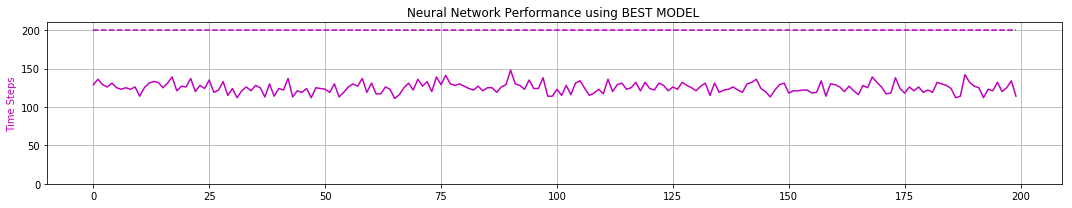

peak memory: 1448.54 MiB, increment: 998.33 MiB
0 -max- [ 0.162  0.829  0.050  0.795]
0 -min- [-1.726 -2.586 -0.209 -1.250]

1 -max- [ 0.141  0.827  0.050  0.717]
1 -min- [-2.345 -3.124 -0.209 -1.210]

2 -max- [ 0.168  0.953  0.050  0.743]
2 -min- [-2.024 -2.780 -0.209 -1.445]

3 -max- [ 0.160  0.827  0.050  0.694]
3 -min- [-2.390 -3.074 -0.209 -1.194]

4 -max- [ 0.182  0.824  0.050  0.902]
4 -min- [-2.024 -2.784 -0.209 -1.194]

5 -max- [ 0.175  0.940  0.051  0.689]
5 -min- [-1.717 -2.591 -0.209 -1.349]

6 -max- [ 0.181  0.976  0.049  0.917]
6 -min- [-2.371 -3.113 -0.209 -1.431]

7 -max- [ 0.177  0.827  0.047  0.729]
7 -min- [-2.364 -3.113 -0.209 -1.198]

8 -max- [ 0.167  0.924  0.048  0.700]
8 -min- [-1.713 -2.570 -0.209 -1.453]

9 -max- [ 0.165  0.824  0.049  0.694]
9 -min- [-2.399 -3.254 -0.209 -1.279]

Quantization TIME:  0.01 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   100221
SMALLEST TIMESTEP: 65
LARGEST  TIMESTEP: 138
TOTAL SERIAL TIMESTEPS:   358431
TOTAL PARALLEL TIM

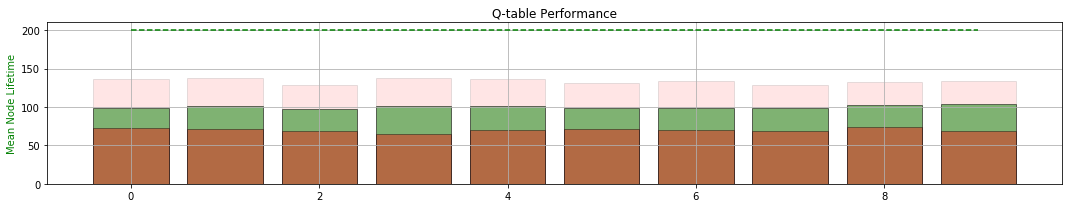

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 115.945	LOSS : 124.177	LOSS : 128.740	LOSS : 115.975	LOSS : 114.933	LOSS : 139.587	LOSS : 140.192	LOSS : 128.394	LOSS : 135.989	LOSS : 133.781	LOSS : 127.299	LOSS : 150.757	LOSS : 130.521	LOSS : 139.208	LOSS : 134.158	LOSS : 147.524	LOSS : 137.225	LOSS : 141.163	LOSS : 120.576	LOSS : 135.854	
Validating... MEAN TIME:  105.58
LOSS : 135.709	LOSS : 128.146	LOSS : 127.622	LOSS : 129.299	LOSS : 133.543	LOSS : 136.041	LOSS : 147.125	LOSS : 143.110	LOSS : 125.623	LOSS : 126.370	LOSS : 127.390	LOSS : 127.776	LOSS : 126.162	LOSS : 129.047	LOSS : 121.075	LOSS : 114.057	LOSS : 123.980	LOSS : 135.201	LOSS : 133.308	LOSS : 130.496	
Validating... MEAN TIME:  104.875
LOSS : 125.511	LOSS : 139.064	LOSS : 132.436	LOSS : 138.520	LOSS : 122.890	LOSS : 122.172	LOSS : 127.766	LOSS : 127.988	LOSS : 136.340	LOSS : 140.646	LOSS : 134.682	LOSS : 128.666	LOSS : 122.665	LOSS : 126.054	LOSS : 139.770	LOSS : 148.890	LOSS : 1

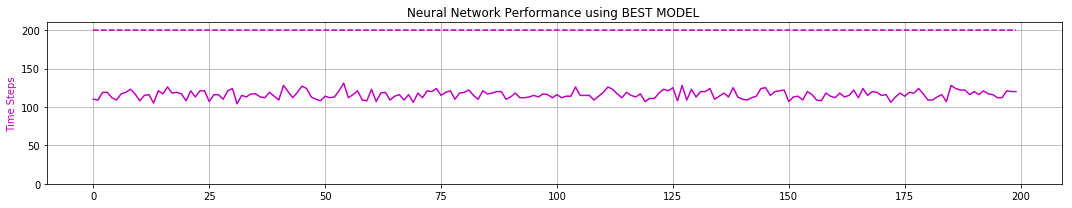

peak memory: 1468.07 MiB, increment: 1036.27 MiB
0 -max- [ 0.105  0.826  0.050  0.668]
0 -min- [-2.400 -3.147 -0.209 -1.187]

1 -max- [ 0.121  0.822  0.050  0.926]
1 -min- [-2.398 -3.154 -0.209 -1.179]

2 -max- [ 0.121  0.827  0.050  0.719]
2 -min- [-2.399 -3.148 -0.209 -1.220]

3 -max- [ 0.132  0.824  0.049  0.782]
3 -min- [-2.400 -3.150 -0.209 -1.186]

4 -max- [ 0.123  0.940  0.051  0.746]
4 -min- [-2.400 -3.154 -0.209 -1.349]

5 -max- [ 0.144  1.014  0.049  0.723]
5 -min- [-2.398 -3.153 -0.209 -1.406]

6 -max- [ 0.128  0.969  0.050  1.028]
6 -min- [-2.399 -3.139 -0.209 -1.339]

7 -max- [ 0.115  0.820  0.048  0.958]
7 -min- [-2.400 -3.143 -0.209 -1.172]

8 -max- [ 0.118  0.976  0.049  0.663]
8 -min- [-2.399 -3.155 -0.209 -1.428]

9 -max- [ 0.124  0.827  0.049  0.659]
9 -min- [-2.399 -3.246 -0.209 -1.187]

Quantization TIME:  0.01 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   125598
SMALLEST TIMESTEP: 27
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   484029
TOTAL PARALLEL TI

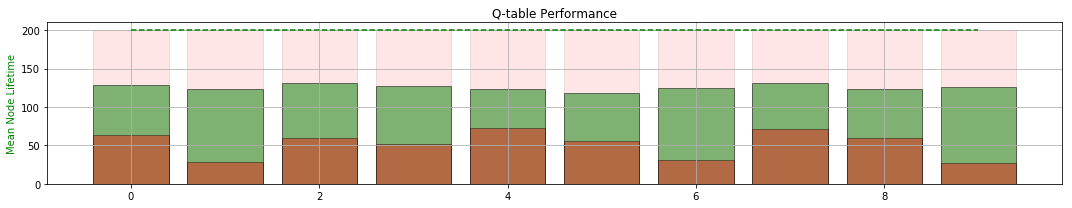

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 118.155	LOSS : 121.153	LOSS : 138.944	LOSS : 124.425	LOSS : 123.963	LOSS : 112.104	LOSS : 106.770	LOSS : 107.997	LOSS : 105.793	LOSS : 121.130	LOSS : 124.528	LOSS : 103.522	LOSS : 111.127	LOSS : 114.714	LOSS : 113.778	LOSS : 121.874	LOSS : 115.406	LOSS : 132.453	LOSS : 117.653	LOSS : 114.321	
Validating... MEAN TIME:  118.655
LOSS : 126.412	LOSS : 114.379	LOSS : 127.170	LOSS : 115.040	LOSS : 110.644	LOSS : 122.110	LOSS : 119.490	LOSS : 114.090	LOSS : 118.789	LOSS : 128.352	LOSS : 111.665	LOSS : 117.569	LOSS : 122.410	LOSS : 111.292	LOSS : 113.651	LOSS : 119.951	LOSS : 125.405	LOSS : 120.162	LOSS : 139.401	LOSS : 134.453	
Validating... MEAN TIME:  113.475
LOSS : 122.259	LOSS : 135.048	LOSS : 120.560	LOSS : 113.447	LOSS : 121.173	LOSS : 115.919	LOSS : 123.563	LOSS : 119.213	LOSS : 112.765	LOSS : 119.886	LOSS : 111.688	LOSS : 103.231	LOSS : 114.433	LOSS : 105.618	LOSS : 98.258	LOSS : 134.391	LOSS : 1

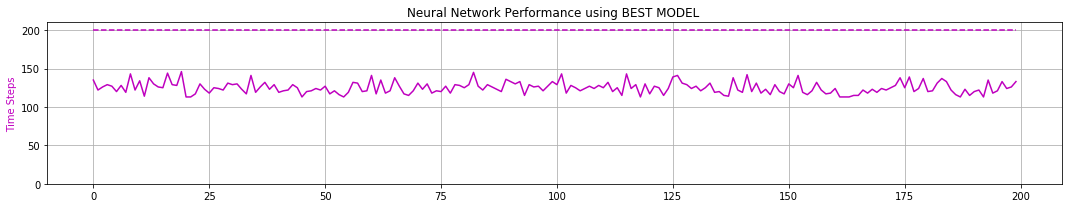

peak memory: 1473.47 MiB, increment: 978.80 MiB
0 -max- [ 0.560  1.734  0.209  2.490]
0 -min- [-2.400 -3.157 -0.209 -1.706]

1 -max- [ 0.752  2.041  0.208  2.676]
1 -min- [-2.400 -3.154 -0.209 -1.805]

2 -max- [ 0.706  1.840  0.209  2.740]
2 -min- [-2.400 -3.157 -0.209 -1.724]

3 -max- [ 0.685  1.737  0.208  2.480]
3 -min- [-2.400 -3.156 -0.209 -1.647]

4 -max- [ 0.736  2.054  0.209  2.698]
4 -min- [-2.400 -3.331 -0.209 -1.784]

5 -max- [ 0.831  2.067  0.209  2.531]
5 -min- [-2.399 -3.160 -0.207 -1.793]

6 -max- [ 0.805  1.908  0.209  2.666]
6 -min- [-2.398 -3.313 -0.209 -1.780]

7 -max- [ 0.747  1.940  0.209  2.496]
7 -min- [-2.400 -3.158 -0.209 -1.789]

8 -max- [ 0.643  1.892  0.209  2.495]
8 -min- [-2.400 -3.157 -0.209 -1.661]

9 -max- [ 0.695  1.898  0.209  2.473]
9 -min- [-2.398 -3.160 -0.209 -1.620]

Quantization TIME:  0.01 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   103767
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 176
TOTAL SERIAL TIMESTEPS:   587796
TOTAL PARALLEL TIM

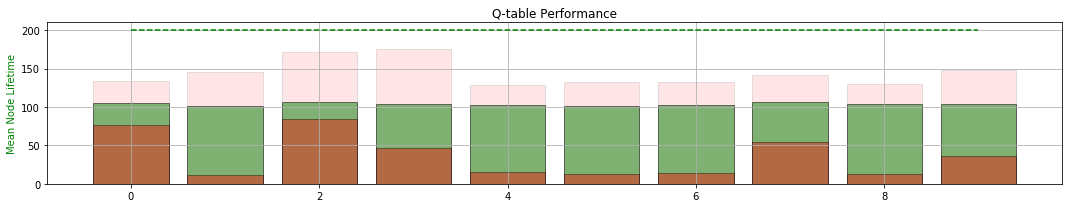

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 126.067	LOSS : 126.453	LOSS : 127.705	LOSS : 144.889	LOSS : 140.858	LOSS : 132.318	LOSS : 139.551	LOSS : 169.166	LOSS : 144.389	LOSS : 147.109	LOSS : 144.563	LOSS : 137.320	LOSS : 138.603	LOSS : 128.635	LOSS : 134.573	LOSS : 156.527	LOSS : 157.547	LOSS : 137.875	LOSS : 140.926	LOSS : 119.274	
Validating... MEAN TIME:  132.44
LOSS : 137.816	LOSS : 145.111	LOSS : 140.348	LOSS : 138.261	LOSS : 163.578	LOSS : 137.568	LOSS : 135.157	LOSS : 149.542	LOSS : 137.413	LOSS : 141.363	LOSS : 126.351	LOSS : 144.612	LOSS : 154.340	LOSS : 129.782	LOSS : 136.049	LOSS : 115.229	LOSS : 157.176	LOSS : 124.038	LOSS : 151.371	LOSS : 137.763	
Validating... MEAN TIME:  137.515
LOSS : 140.317	LOSS : 149.620	LOSS : 150.500	LOSS : 135.890	LOSS : 152.561	LOSS : 142.963	LOSS : 137.987	LOSS : 151.206	LOSS : 158.062	LOSS : 150.635	LOSS : 161.496	LOSS : 142.125	LOSS : 155.326	LOSS : 148.959	LOSS : 150.441	LOSS : 133.311	LOSS : 1

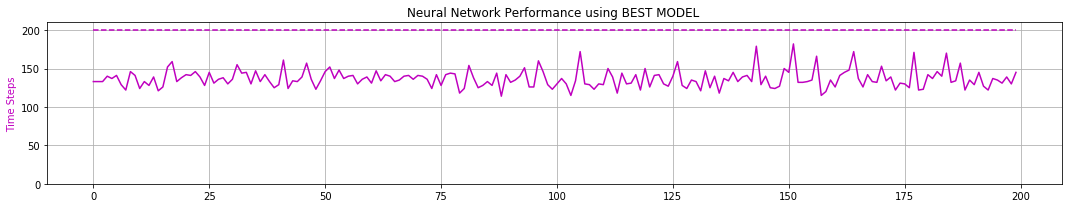

peak memory: 1401.42 MiB, increment: 1017.75 MiB
0 -max- [ 0.154  1.204  0.050  1.211]
0 -min- [-2.393 -3.342 -0.209 -1.759]

1 -max- [ 0.167  1.213  0.049  1.238]
1 -min- [-2.396 -3.148 -0.209 -1.758]

2 -max- [ 0.167  1.201  0.051  1.211]
2 -min- [-2.399 -3.277 -0.209 -1.725]

3 -max- [ 0.154  1.204  0.049  1.165]
3 -min- [-2.390 -3.263 -0.209 -1.746]

4 -max- [ 0.162  1.211  0.047  1.235]
4 -min- [-2.387 -3.140 -0.209 -1.740]

5 -max- [ 0.155  1.174  0.048  1.233]
5 -min- [-2.386 -3.130 -0.209 -1.758]

6 -max- [ 0.163  1.209  0.049  1.237]
6 -min- [-2.399 -3.156 -0.209 -1.743]

7 -max- [ 0.159  1.204  0.049  1.121]
7 -min- [-2.397 -3.283 -0.209 -1.726]

8 -max- [ 0.180  1.406  0.050  1.191]
8 -min- [-2.399 -3.131 -0.209 -1.968]

9 -max- [ 0.167  1.212  0.048  1.204]
9 -min- [-2.391 -3.135 -0.209 -1.741]

Quantization TIME:  0.01 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   127613
SMALLEST TIMESTEP: 72
LARGEST  TIMESTEP: 190
TOTAL SERIAL TIMESTEPS:   715409
TOTAL PARALLEL TI

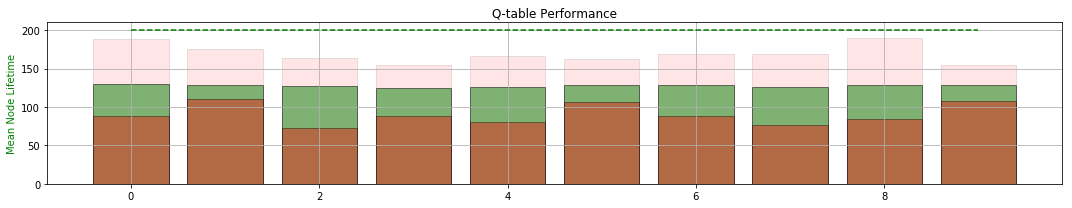

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 152.960	LOSS : 151.477	LOSS : 158.386	LOSS : 142.910	LOSS : 151.872	LOSS : 123.607	LOSS : 142.825	LOSS : 149.488	LOSS : 139.979	LOSS : 159.214	LOSS : 133.143	LOSS : 134.125	LOSS : 153.371	LOSS : 133.593	LOSS : 134.068	LOSS : 145.002	LOSS : 133.348	LOSS : 148.606	LOSS : 154.128	LOSS : 150.986	
Validating... MEAN TIME:  115.74
LOSS : 148.385	LOSS : 158.676	LOSS : 136.294	LOSS : 140.712	LOSS : 122.773	LOSS : 159.555	LOSS : 151.479	LOSS : 131.397	LOSS : 137.807	LOSS : 151.879	LOSS : 141.771	LOSS : 116.806	LOSS : 148.979	LOSS : 126.875	LOSS : 127.633	LOSS : 143.880	LOSS : 137.488	LOSS : 130.691	LOSS : 134.419	LOSS : 134.340	
Validating... MEAN TIME:  120.46
LOSS : 138.355	LOSS : 144.253	LOSS : 137.533	LOSS : 121.510	LOSS : 131.153	LOSS : 145.532	LOSS : 145.913	LOSS : 123.038	LOSS : 134.070	LOSS : 146.199	LOSS : 127.647	LOSS : 113.515	LOSS : 149.761	LOSS : 124.624	LOSS : 141.125	LOSS : 128.708	LOSS : 15

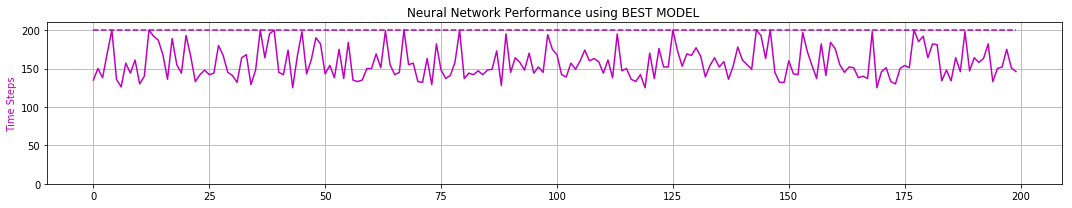

peak memory: 1447.68 MiB, increment: 1017.62 MiB
0 -max- [ 0.122  0.823  0.049  0.996]
0 -min- [-2.399 -3.299 -0.209 -1.168]

1 -max- [ 0.122  0.940  0.051  1.052]
1 -min- [-2.400 -3.322 -0.209 -1.386]

2 -max- [ 0.128  0.980  0.051  1.022]
2 -min- [-2.399 -3.140 -0.209 -1.333]

3 -max- [ 0.109  0.821  0.047  0.936]
3 -min- [-2.399 -3.143 -0.208 -1.199]

4 -max- [ 0.107  0.815  0.048  1.025]
4 -min- [-2.399 -3.166 -0.209 -1.226]

5 -max- [ 0.115  0.819  0.049  0.977]
5 -min- [-2.399 -3.145 -0.209 -1.177]

6 -max- [ 0.118  0.827  0.049  0.946]
6 -min- [-2.400 -3.331 -0.208 -1.176]

7 -max- [ 0.135  1.017  0.050  0.947]
7 -min- [-2.400 -3.155 -0.209 -1.356]

8 -max- [ 0.110  0.822  0.048  1.080]
8 -min- [-2.400 -3.147 -0.209 -1.152]

9 -max- [ 0.113  0.814  0.045  1.016]
9 -min- [-2.399 -3.138 -0.208 -1.172]

Quantization TIME:  0.01 minutes


ITERATION # 8
TOTAL EXPERIENCE GENERATED:   168908
SMALLEST TIMESTEP: 135
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   884317
TOTAL PARALLEL T

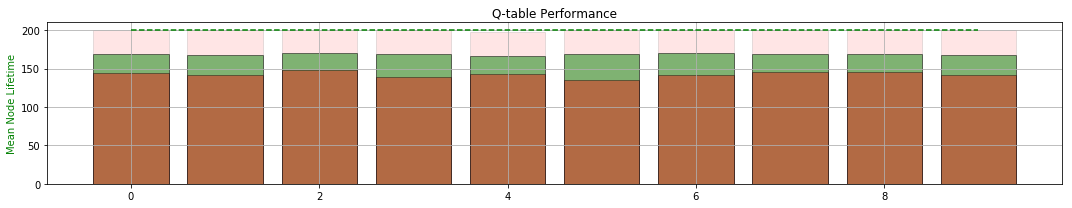

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 109.664	LOSS : 83.757	LOSS : 82.301	LOSS : 84.500	LOSS : 83.216	LOSS : 79.027	LOSS : 75.615	LOSS : 70.468	LOSS : 69.895	LOSS : 75.336	LOSS : 78.122	LOSS : 74.345	LOSS : 78.833	LOSS : 85.529	LOSS : 85.638	LOSS : 76.712	LOSS : 89.655	LOSS : 93.668	LOSS : 70.127	LOSS : 83.938	
Validating... MEAN TIME:  132.375
LOSS : 76.615	LOSS : 74.284	LOSS : 83.334	LOSS : 82.721	LOSS : 81.506	LOSS : 85.770	LOSS : 79.940	LOSS : 74.494	LOSS : 88.646	LOSS : 76.417	LOSS : 82.178	LOSS : 89.830	LOSS : 71.064	LOSS : 84.182	LOSS : 83.048	LOSS : 83.397	LOSS : 83.070	LOSS : 76.637	LOSS : 81.612	LOSS : 75.003	
Validating... MEAN TIME:  122.135
LOSS : 81.757	LOSS : 73.854	LOSS : 68.386	LOSS : 85.857	LOSS : 72.233	LOSS : 74.064	LOSS : 70.074	LOSS : 86.783	LOSS : 78.662	LOSS : 78.361	LOSS : 78.938	LOSS : 77.724	LOSS : 72.694	LOSS : 67.046	LOSS : 63.021	LOSS : 68.688	LOSS : 69.334	LOSS : 80.029	LOSS : 67.292	LOSS : 77.377	
Valid

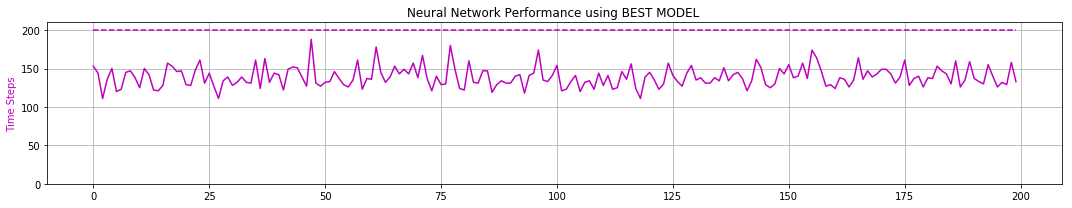

peak memory: 1458.27 MiB, increment: 1017.49 MiB
0 -max- [ 1.817  1.883  0.209  1.673]
0 -min- [-0.116 -0.942 -0.050 -1.018]

1 -max- [ 1.869  1.877  0.209  1.595]
1 -min- [-0.107 -0.819 -0.052 -1.254]

2 -max- [ 1.825  1.869  0.209  1.605]
2 -min- [-0.134 -0.825 -0.052 -1.265]

3 -max- [ 1.862  1.867  0.209  1.509]
3 -min- [-0.114 -0.827 -0.050 -1.097]

4 -max- [ 1.834  1.881  0.209  1.658]
4 -min- [-0.110 -0.821 -0.050 -1.460]

5 -max- [ 1.849  1.971  0.209  1.344]
5 -min- [-0.141 -0.824 -0.048 -1.272]

6 -max- [ 1.868  1.864  0.209  1.332]
6 -min- [-0.139 -0.817 -0.049 -1.012]

7 -max- [ 1.834  1.869  0.209  1.187]
7 -min- [-0.109 -0.828 -0.050 -0.996]

8 -max- [ 1.847  1.975  0.209  1.509]
8 -min- [-0.155 -0.818 -0.050 -1.242]

9 -max- [ 1.831  2.067  0.209  1.599]
9 -min- [-0.114 -0.823 -0.053 -1.262]

Quantization TIME:  0.01 minutes


ITERATION # 9
TOTAL EXPERIENCE GENERATED:   104170
SMALLEST TIMESTEP: 77
LARGEST  TIMESTEP: 166
TOTAL SERIAL TIMESTEPS:   988487
TOTAL PARALLEL TI

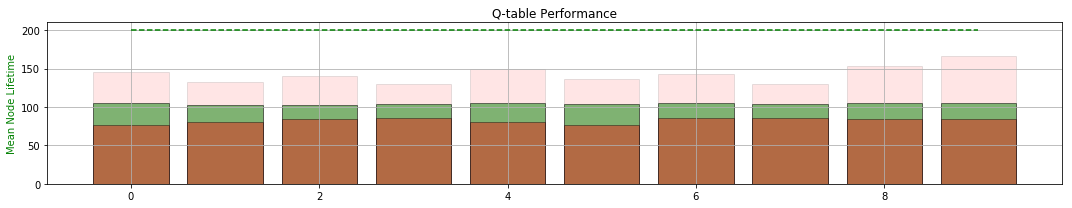

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 101.245	LOSS : 84.472	LOSS : 85.552	LOSS : 81.064	LOSS : 94.560	LOSS : 79.955	LOSS : 93.680	LOSS : 101.636	LOSS : 99.422	LOSS : 88.676	LOSS : 87.308	LOSS : 86.192	LOSS : 93.571	LOSS : 104.194	LOSS : 90.094	LOSS : 89.380	LOSS : 92.854	LOSS : 93.927	LOSS : 93.384	LOSS : 88.290	
Validating... MEAN TIME:  131.855
LOSS : 90.823	LOSS : 89.842	LOSS : 91.621	LOSS : 102.284	LOSS : 89.254	LOSS : 92.749	LOSS : 95.111	LOSS : 96.333	LOSS : 94.705	LOSS : 98.650	LOSS : 123.436	LOSS : 101.555	LOSS : 87.884	LOSS : 107.155	LOSS : 113.956	LOSS : 96.047	LOSS : 104.434	LOSS : 120.119	LOSS : 113.582	LOSS : 98.708	
Validating... MEAN TIME:  199.495
LOSS : 106.129	LOSS : 106.242	LOSS : 113.980	LOSS : 87.686	LOSS : 111.669	LOSS : 84.185	LOSS : 114.423	LOSS : 98.931	LOSS : 101.772	LOSS : 97.419	LOSS : 97.980	LOSS : 104.837	LOSS : 94.367	LOSS : 95.682	LOSS : 98.555	LOSS : 96.563	LOSS : 88.818	LOSS : 81.891	LOSS : 92.632	LOS

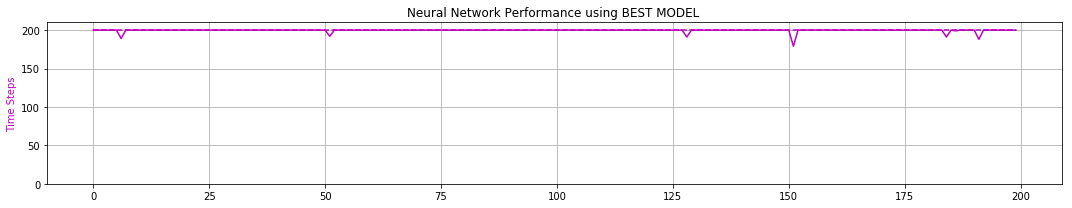

peak memory: 1452.08 MiB, increment: 1034.82 MiB
0 -max- [ 0.119  0.819  0.049  0.809]
0 -min- [-1.786 -2.425 -0.209 -1.161]

1 -max- [ 0.115  0.821  0.047  1.014]
1 -min- [-1.779 -2.432 -0.209 -1.153]

2 -max- [ 0.111  0.812  0.048  0.925]
2 -min- [-1.788 -2.425 -0.209 -1.435]

3 -max- [ 0.115  0.819  0.049  0.992]
3 -min- [-1.719 -2.421 -0.209 -1.153]

4 -max- [ 0.118  0.827  0.049  0.898]
4 -min- [-1.732 -2.420 -0.209 -1.165]

5 -max- [ 0.135  1.017  0.050  0.941]
5 -min- [-1.703 -2.428 -0.209 -1.356]

6 -max- [ 0.113  0.822  0.048  0.728]
6 -min- [-1.690 -2.419 -0.209 -1.197]

7 -max- [ 0.101  0.814  0.045  0.720]
7 -min- [-1.678 -2.424 -0.209 -1.172]

8 -max- [ 0.141  1.011  0.053  0.838]
8 -min- [-1.781 -2.413 -0.209 -1.361]

9 -max- [ 0.130  0.826  0.049  1.024]
9 -min- [-1.752 -2.420 -0.209 -1.175]

Quantization TIME:  0.01 minutes


ITERATION # 10
TOTAL EXPERIENCE GENERATED:   144415
SMALLEST TIMESTEP: 83
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1132902
TOTAL PARALLEL 

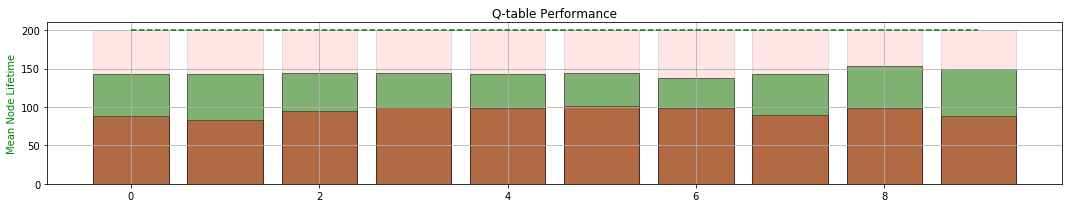

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 156.249	LOSS : 168.575	LOSS : 195.101	LOSS : 172.756	LOSS : 134.479	LOSS : 167.880	LOSS : 139.115	LOSS : 144.167	LOSS : 144.195	LOSS : 123.299	LOSS : 144.341	LOSS : 128.588	LOSS : 112.380	LOSS : 97.873	LOSS : 110.496	LOSS : 98.394	LOSS : 100.918	LOSS : 91.933	LOSS : 87.535	LOSS : 89.825	
Validating... MEAN TIME:  9.92
LOSS : 92.410	LOSS : 92.308	LOSS : 95.927	LOSS : 96.731	LOSS : 96.585	LOSS : 120.121	LOSS : 112.978	LOSS : 96.571	LOSS : 118.417	LOSS : 127.683	LOSS : 131.386	LOSS : 116.170	LOSS : 117.557	LOSS : 97.800	LOSS : 97.832	LOSS : 101.908	LOSS : 97.934	LOSS : 97.231	LOSS : 122.969	LOSS : 95.475	
Validating... MEAN TIME:  15.215
LOSS : 109.757	LOSS : 91.247	LOSS : 103.830	LOSS : 111.986	LOSS : 96.003	LOSS : 78.721	LOSS : 74.944	LOSS : 92.078	LOSS : 77.726	LOSS : 86.263	LOSS : 98.074	LOSS : 81.678	LOSS : 78.503	LOSS : 76.327	LOSS : 100.980	LOSS : 96.893	LOSS : 109.014	LOSS : 110.212	LOSS : 91

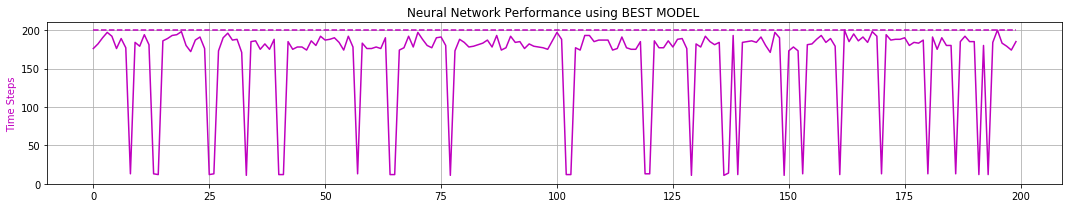

peak memory: 1415.59 MiB, increment: 939.62 MiB
0 -max- [ 0.136  1.699  0.200  1.019]
0 -min- [-2.398 -3.155 -0.209 -1.730]

1 -max- [ 0.147  1.374  0.208  0.999]
1 -min- [-2.383 -3.114 -0.209 -1.524]

2 -max- [ 0.155  1.723  0.204  1.051]
2 -min- [-2.390 -3.154 -0.209 -1.756]

3 -max- [ 0.159  1.902  0.206  0.952]
3 -min- [-2.397 -2.963 -0.209 -1.924]

4 -max- [ 0.978  1.517  0.203  0.976]
4 -min- [-2.379 -3.149 -0.209 -1.604]

5 -max- [ 0.153  1.545  0.190  0.832]
5 -min- [-2.394 -3.156 -0.209 -1.623]

6 -max- [ 0.114  1.355  0.209  0.876]
6 -min- [-2.399 -3.155 -0.209 -1.495]

7 -max- [ 0.994  1.378  0.209  1.529]
7 -min- [-2.380 -3.148 -0.209 -1.412]

8 -max- [ 0.893  1.740  0.208  1.333]
8 -min- [-2.388 -3.142 -0.209 -1.813]

9 -max- [ 1.174  1.902  0.208  0.994]
9 -min- [-2.378 -2.970 -0.209 -1.937]

Quantization TIME:  0.01 minutes


ITERATION # 11
TOTAL EXPERIENCE GENERATED:   181807
SMALLEST TIMESTEP: 14
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1314709
TOTAL PARALLEL T

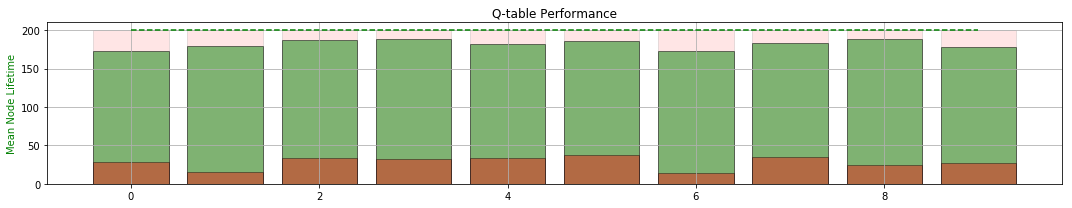

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 90.713	LOSS : 71.498	LOSS : 61.960	LOSS : 63.738	LOSS : 85.322	LOSS : 108.540	LOSS : 91.318	LOSS : 85.864	LOSS : 97.889	LOSS : 79.994	LOSS : 103.326	LOSS : 86.977	LOSS : 104.461	LOSS : 99.048	LOSS : 109.129	LOSS : 96.680	LOSS : 97.181	LOSS : 85.585	LOSS : 93.477	LOSS : 87.087	
Validating... MEAN TIME:  10.195
LOSS : 81.347	LOSS : 80.027	LOSS : 109.338	LOSS : 86.308	LOSS : 104.180	LOSS : 90.542	LOSS : 80.404	LOSS : 79.471	LOSS : 77.464	LOSS : 78.593	LOSS : 87.918	LOSS : 74.189	LOSS : 76.778	LOSS : 62.192	LOSS : 70.813	LOSS : 74.969	LOSS : 73.168	LOSS : 79.312	LOSS : 78.573	LOSS : 66.473	
Validating... MEAN TIME:  11.4
LOSS : 77.901	LOSS : 83.728	LOSS : 73.464	LOSS : 67.436	LOSS : 76.441	LOSS : 72.023	LOSS : 69.534	LOSS : 70.722	LOSS : 73.060	LOSS : 66.770	LOSS : 62.247	LOSS : 66.586	LOSS : 68.557	LOSS : 68.638	LOSS : 69.284	LOSS : 66.878	LOSS : 70.060	LOSS : 80.069	LOSS : 72.983	LOSS : 87.799	
Vali

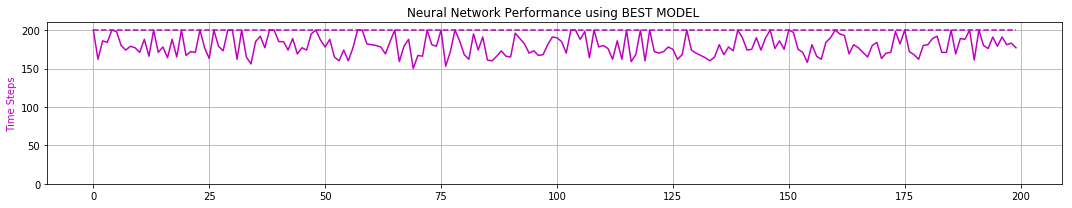

peak memory: 1474.36 MiB, increment: 1005.75 MiB
0 -max- [ 1.228  1.953  0.207  2.457]
0 -min- [-0.170 -1.915 -0.209 -2.376]

1 -max- [ 1.037  1.955  0.208  2.503]
1 -min- [-0.162 -1.971 -0.209 -2.229]

2 -max- [ 0.888  1.893  0.208  2.589]
2 -min- [-0.179 -2.114 -0.207 -2.261]

3 -max- [ 0.979  1.967  0.203  1.939]
3 -min- [-0.168 -1.526 -0.206 -2.230]

4 -max- [ 0.924  1.895  0.206  2.507]
4 -min- [-0.204 -1.980 -0.209 -2.312]

5 -max- [ 0.849  1.883  0.206  2.483]
5 -min- [-0.203 -1.904 -0.208 -2.250]

6 -max- [ 1.010  1.916  0.209  2.351]
6 -min- [-0.191 -1.907 -0.209 -2.340]

7 -max- [ 1.079  1.889  0.208  2.508]
7 -min- [-0.152 -1.916 -0.208 -2.304]

8 -max- [ 1.124  1.930  0.204  2.186]
8 -min- [-0.162 -1.688 -0.209 -2.308]

9 -max- [ 0.932  1.963  0.209  2.484]
9 -min- [-0.172 -1.932 -0.209 -2.257]

Quantization TIME:  0.01 minutes


ITERATION # 12
TOTAL EXPERIENCE GENERATED:   165502
SMALLEST TIMESTEP: 46
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1480211
TOTAL PARALLEL 

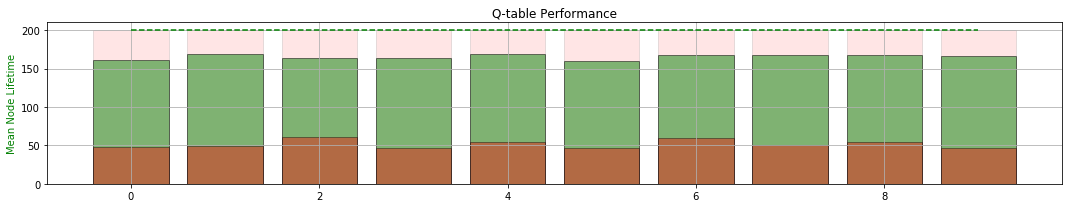

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 87.255	LOSS : 76.408	LOSS : 78.671	LOSS : 78.730	LOSS : 56.135	LOSS : 66.970	LOSS : 73.981	LOSS : 79.160	LOSS : 63.446	LOSS : 70.647	LOSS : 72.967	LOSS : 81.834	LOSS : 58.678	LOSS : 76.578	LOSS : 57.636	LOSS : 69.142	LOSS : 58.219	LOSS : 61.611	LOSS : 72.712	LOSS : 59.380	
Validating... MEAN TIME:  9.64
LOSS : 54.635	LOSS : 72.604	LOSS : 71.706	LOSS : 62.714	LOSS : 60.093	LOSS : 65.773	LOSS : 54.107	LOSS : 61.954	LOSS : 66.888	LOSS : 60.341	LOSS : 73.518	LOSS : 65.245	LOSS : 77.017	LOSS : 65.322	LOSS : 56.165	LOSS : 60.523	LOSS : 62.946	LOSS : 58.787	LOSS : 61.016	LOSS : 66.643	
Validating... MEAN TIME:  10.35
LOSS : 74.398	LOSS : 71.916	LOSS : 67.464	LOSS : 66.480	LOSS : 63.402	LOSS : 64.387	LOSS : 63.255	LOSS : 71.585	LOSS : 56.137	LOSS : 60.760	LOSS : 68.036	LOSS : 69.918	LOSS : 56.464	LOSS : 60.354	LOSS : 59.376	LOSS : 62.580	LOSS : 62.231	LOSS : 64.000	LOSS : 56.214	LOSS : 56.274	
Validating.

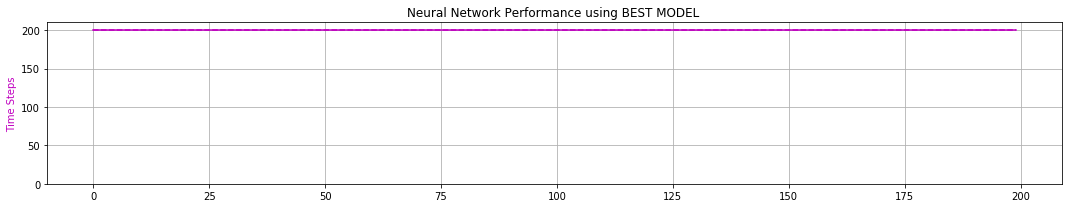

peak memory: 1449.58 MiB, increment: 1034.54 MiB
0 -max- [ 0.429  1.389  0.146  1.517]
0 -min- [-2.240 -2.922 -0.209 -1.594]

1 -max- [ 0.424  1.393  0.103  1.415]
1 -min- [-1.832 -2.749 -0.209 -1.615]

2 -max- [ 0.426  1.388  0.098  1.260]
2 -min- [-1.424 -2.391 -0.209 -1.631]

3 -max- [ 0.413  1.342  0.096  1.257]
3 -min- [-2.374 -2.936 -0.209 -1.565]

4 -max- [ 0.424  1.353  0.098  1.258]
4 -min- [-1.459 -2.571 -0.209 -1.599]

5 -max- [ 0.422  1.337  0.110  1.513]
5 -min- [-1.042 -2.209 -0.209 -1.561]

6 -max- [ 0.421  1.341  0.095  1.443]
6 -min- [-2.384 -3.094 -0.209 -1.579]

7 -max- [ 0.435  1.344  0.136  1.588]
7 -min- [-2.375 -3.287 -0.209 -1.558]

8 -max- [ 0.409  1.387  0.097  1.259]
8 -min- [-1.523 -2.392 -0.209 -1.609]

9 -max- [ 0.414  1.341  0.111  1.525]
9 -min- [-1.076 -1.478 -0.209 -1.554]

Quantization TIME:  0.01 minutes


ITERATION # 13
TOTAL EXPERIENCE GENERATED:   199996
SMALLEST TIMESTEP: 196
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1680207
TOTAL PARALLEL

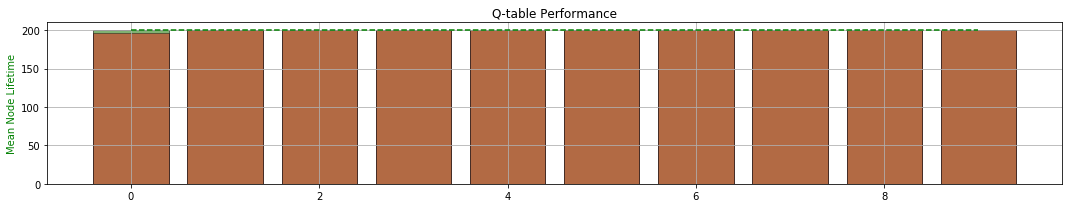

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  2364.0
Total Serial Timesteps   :  1680207.0
Speed-up                 :  710.75


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  7551 SUCCESS 196  13    2364    1680207     710.75
